In [1]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as pl

In [2]:
# read all confirmed planets from the exoplanet archive
planets = Table.read('../planets2.txt', format='csv', comment='#')

In [3]:
# habitable zone as a function of teff from https://iopscience.iop.org/article/10.1088/0004-637X/765/2/131/pdf

# valid from teff=2600 to 7200 K, T = T* - 5780

# moist greenhouse
coeffs_rv = 1.7763, 1.4335e-4, 3.3954e-9, -7.6364e-12, -1.1950e-15
coeffs_moistgh = 1.0146, 8.1884e-5, 1.9394e-9, -4.3618e-12, -6.8260e-16
coeffs_maxgh = 0.3507, 5.9578e-5, 1.6707e-99, -3.0058e-12, -5.1925e-16
coeffs_em = 0.3207, 5.4471e-5, 1.5275e-9, -2.1709e-12, -3.8282e16

# inner and outer habitable zone insolations 
coeffs_inner = coeffs_rv
coeffs_outer = coeffs_em
hz_inner = lambda T: (coeffs_inner[0] 
                      + coeffs_inner[1]*T 
                      + coeffs_inner[2]*(T**2) 
                      + coeffs_inner[3]*(T**3) 
                      + coeffs_inner[4]*(T**4))
hz_outer = lambda T: (coeffs_outer[0] 
                      + coeffs_outer[1]*T 
                      + coeffs_outer[2]*(T**2) 
                      + coeffs_outer[3]*(T**3) 
                      + coeffs_outer[4]*(T**4))

In [5]:
teff_sol = 5777 
lum = (planets['st_rad'] ** 2) * (planets['st_teff']/teff_sol) ** 4
seff = (lum / planets['pl_orbsmax']**2)
#in_hz = (seff > hz_outer(planets['st_teff']-5780)) & (seff < hz_inner(planets['st_teff']-5780))
#beyond_hz = (seff < hz_outer(planets['st_teff']-5780))
#in_hz = in_hz & ~seff.mask
in_hz = seff < hz_inner(planets['st_teff']-5780)
in_hz = in_hz & ~seff.mask
#beyond_hz = beyond_hz & ~seff.mask

In [6]:
import sys
sys.path.append('../forecaster')
import mr_forecast as mr

In [7]:
minmass_med = np.zeros(len(planets[in_hz]))
minmass_minus = np.zeros(len(planets[in_hz]))
minmass_plus = np.zeros(len(planets[in_hz]))
for i, p in enumerate(planets[in_hz]):
    if (p['pl_radj'] is np.ma.masked) & (p['pl_rade'] is np.ma.masked):
        minmass_med[i] = -1
        minmass_minus[i] = -1
        minmass_plus[i] = -1
    else:
        if p['pl_radj'] is np.ma.masked:
            res = mr.Rstat2M(mean=p['pl_rade'] / 11.2089, std=p['pl_radeerr1'] / 11.2089, unit='Jupiter', sample_size=100, grid_size=100)
        else:
            res = mr.Rstat2M(mean=p['pl_radj'], std=p['pl_radjerr1'], unit='Jupiter', sample_size=100, grid_size=100)
        if res is not None:
            m, mminus, mplus = res
            minmass_med[i] = m
            minmass_minus[i] = mminus
            minmass_plus[i] = mplus
        else:
            minmass_med[i] = -1
            minmass_minus[i] = -1
            minmass_plus[i] = -1

../forecaster/mr_forecast.py:256: RuntimeWarning: divide by zero encountered in true_divide
  radius = truncnorm.rvs( (0.-mean)/std, np.inf, loc=mean, scale=std, size=sample_size)


Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.


../forecaster/mr_forecast.py:256: RuntimeWarning: divide by zero encountered in double_scalars
  radius = truncnorm.rvs( (0.-mean)/std, np.inf, loc=mean, scale=std, size=sample_size)


Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.


In [8]:
from astropy.table import unique
hz_planets = planets[in_hz]
hz_planets.add_column(np.ma.masked_where(minmass_med == -1, minmass_med), name='pl_minmass_med')
hz_planets.add_column(np.ma.masked_where(minmass_plus == -1, minmass_plus), name='pl_minmass_plus')
hz_planets.add_column(np.ma.masked_where(minmass_minus == -1, minmass_minus), name='pl_minmass_minus')
hz_planets = unique(hz_planets, keys=['pl_name'], keep='last')

In [9]:
mj_ms = 0.0009543
au_rs = 1/215.032
hill = lambda mp, ms, a, e: a * (1 - e) * (mp/(3*ms)) ** (1./3.)
t_hill = lambda mp, ms, a, e, P, rs: (hill(mp, ms, a, e) + rs * au_rs) * P / (2 * np.pi * a)

In [10]:
th = np.zeros(len(hz_planets))
rh = np.zeros(len(hz_planets))
for i, p in enumerate(hz_planets):
    if (p['pl_radj'] is np.ma.masked) & (p['pl_rade'] is np.ma.masked):
        th[i] = 24*t_hill(p['pl_bmassj'] * mj_ms, p['st_mass'], p['pl_orbsmax'], 0.0, p['pl_orbper'], p['st_rad'])
        rh[i] = hill(p['pl_bmassj'] * mj_ms, p['st_mass'], 0.0, p['pl_orbeccen'])# / p['pl_orbsmax']
        #print(p['pl_name'], " ", th[i])
    else:
        th[i] = 24*t_hill(p['pl_minmass_med'] * mj_ms, p['st_mass'], p['pl_orbsmax'], 0.0, p['pl_orbper'], p['st_rad'])
        rh[i] = hill(p['pl_minmass_med'] * mj_ms, p['st_mass'], p['pl_orbsmax'], 0.0)# / p['pl_orbsmax']
        #print(p['pl_name'], " ", th[i])
hz_planets.add_column(th, name='pl_hilltime')
hz_planets.add_column(rh, name='pl_hillrad')

<ipython-input-10-63f2808c446a>:9: UserWarning: Warning: converting a masked element to nan.
  th[i] = 24*t_hill(p['pl_minmass_med'] * mj_ms, p['st_mass'], p['pl_orbsmax'], 0.0, p['pl_orbper'], p['st_rad'])
<ipython-input-10-63f2808c446a>:5: UserWarning: Warning: converting a masked element to nan.
  th[i] = 24*t_hill(p['pl_bmassj'] * mj_ms, p['st_mass'], p['pl_orbsmax'], 0.0, p['pl_orbper'], p['st_rad'])
<ipython-input-10-63f2808c446a>:6: UserWarning: Warning: converting a masked element to nan.
  rh[i] = hill(p['pl_bmassj'] * mj_ms, p['st_mass'], 0.0, p['pl_orbeccen'])# / p['pl_orbsmax']
<ipython-input-9-196ba5698811>:3: RuntimeWarning: divide by zero encountered in true_divide
  hill = lambda mp, ms, a, e: a * (1 - e) * (mp/(3*ms)) ** (1./3.)
<ipython-input-10-63f2808c446a>:10: UserWarning: Warning: converting a masked element to nan.
  rh[i] = hill(p['pl_minmass_med'] * mj_ms, p['st_mass'], p['pl_orbsmax'], 0.0)# / p['pl_orbsmax']


In [10]:
#c = ((th / 3 * 5) < 100) & (hz_planets['tran_flag'] == 1)
#for i, p in enumerate(hz_planets[c]):
#    print(p['pl_name'], "\t", th[c][i] / 3 * 5, "\t", p['st_teff'], "\t", rh[c][i])

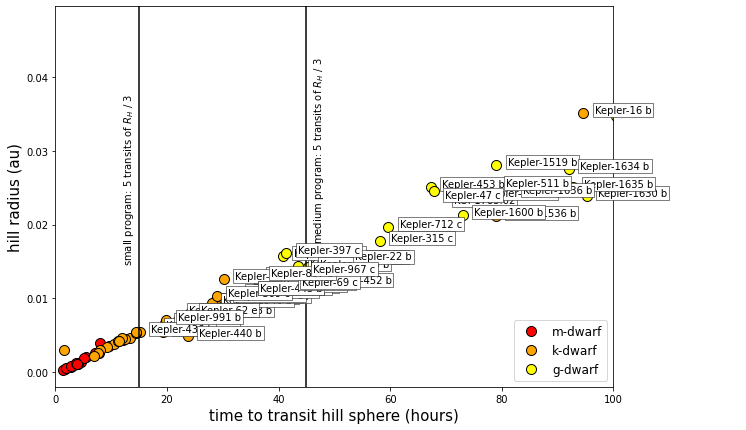

In [11]:
c = ((th / 3 * 5) < 100) & (hz_planets['tran_flag'] == 1)
pl.figure(figsize=(10, 7))
mdwarf = hz_planets[c]['st_teff'] < 3500
kdwarf = (hz_planets[c]['st_teff'] > 3500) & (hz_planets[c]['st_teff'] < 5000)
gdwarf = (hz_planets[c]['st_teff'] > 5000) & (hz_planets[c]['st_teff'] < 6000)
pl.plot(2*th[c][mdwarf], rh[c][mdwarf], 'o', color='red', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='m-dwarf')
pl.plot(2*th[c][kdwarf], rh[c][kdwarf], 'o', color='orange', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='k-dwarf')
pl.plot(2*th[c][gdwarf], rh[c][gdwarf], 'o', color='yellow', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='g-dwarf')
pl.xlim(0, 100)
#pl.ylim(0, 0.06)

for t, r, pname in zip(th[c], rh[c], hz_planets[c]['pl_name']):
    if 2*t > 15:
        if pname == 'Kepler-442 b':
            pl.annotate(pname, xy=(2*t+2, r+0.001), rotation=0, 
                    bbox=dict(fc="white", lw=0.5, pad=2))
        elif pname == 'Kepler-47 c':
            pl.annotate(pname, xy=(2*t+2, r-0.001), rotation=0, 
                    bbox=dict(fc="white", lw=0.5, pad=2))
        else:
            pl.annotate(pname, xy=(2*t+2, r), rotation=0, 
                    bbox=dict(fc="white", lw=0.5, pad=2))

pl.axvline(25 * 3 / 5, color='k')
pl.axvline(75 * 3 / 5, color='k')
pl.annotate(r'small program: 5 transits of $R_H\ /\ 3$', 
            xy=(25 * 3 / 5 - 3, 0.015), rotation=90, fontsize=10)
pl.annotate(r'medium program: 5 transits of $R_H\ /\ 3$', 
            xy=(75 * 3 / 5 + 1, 0.018), rotation=90, fontsize=10)

pl.xlabel('time to transit hill sphere (hours)', fontsize=15)
pl.ylabel('hill radius (au)', fontsize=15)
pl.legend(fontsize=12, loc='lower right')
pl.savefig('/Users/tgordon/Desktop/candidates.pdf')

/usr/local/lib/python3.8/site-packages/matplotlib/text.py:1346: UserWarning: Warning: converting a masked element to nan.
  y = float(self.convert_yunits(y))
/usr/local/lib/python3.8/site-packages/matplotlib/text.py:1346: UserWarning: Warning: converting a masked element to nan.
  y = float(self.convert_yunits(y))
/usr/local/lib/python3.8/site-packages/matplotlib/text.py:823: UserWarning: Warning: converting a masked element to nan.
  y = float(self.convert_yunits(self._y))


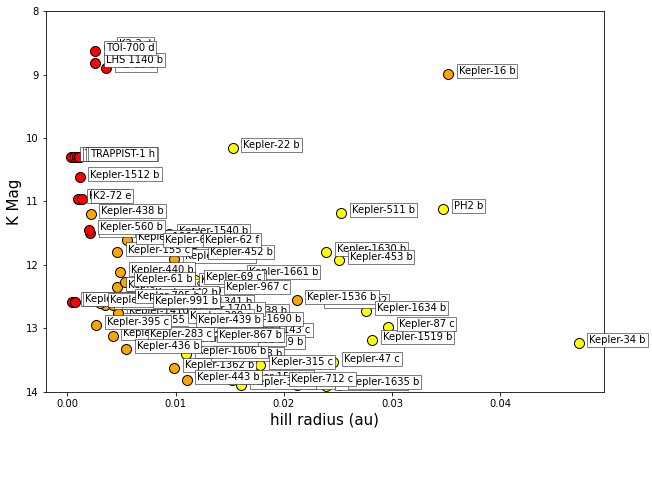

In [14]:
c = ((th / 3 * 5) < 100) & (hz_planets['tran_flag'] == 1)
pl.figure(figsize=(10, 7))
mdwarf = hz_planets[c]['st_teff'] < 3500
kdwarf = (hz_planets[c]['st_teff'] > 3500) & (hz_planets[c]['st_teff'] < 5000)
gdwarf = (hz_planets[c]['st_teff'] > 5000) & (hz_planets[c]['st_teff'] < 6000)
pl.plot(rh[c][mdwarf], hz_planets[c]['sy_kmag'][mdwarf], 'o', color='red', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='m-dwarf')
pl.plot(rh[c][kdwarf], hz_planets[c]['sy_kmag'][kdwarf], 'o', color='orange', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='k-dwarf')
pl.plot(rh[c][gdwarf], hz_planets[c]['sy_kmag'][gdwarf], 'o', color='yellow', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='g-dwarf')
#pl.xlim(0, 100)
pl.ylim(14, 8)

for r, kmag, hname in zip(rh[c], hz_planets[c]['sy_kmag'], hz_planets[c]['pl_name']):
        pl.annotate(hname, xy=(r+0.001, kmag), rotation=0, 
                    bbox=dict(fc="white", lw=0.5, pad=2))

#pl.axvline(25 * 3 / 5, color='k')
#pl.axvline(75 * 3 / 5, color='k')
#pl.annotate(r'small program: 5 transits of $R_H\ /\ 3$', 
#            xy=(25 * 3 / 5 - 3, 0.015), rotation=90, fontsize=10)
#pl.annotate(r'medium program: 5 transits of $R_H\ /\ 3$', 
#            xy=(75 * 3 / 5 + 1, 0.018), rotation=90, fontsize=10)

pl.xlabel('hill radius (au)', fontsize=15)
pl.ylabel('K Mag', fontsize=15)
#pl.legend(fontsize=12, loc='lower right')
pl.savefig('/Users/tgordon/Desktop/candidates_kmag.pdf')

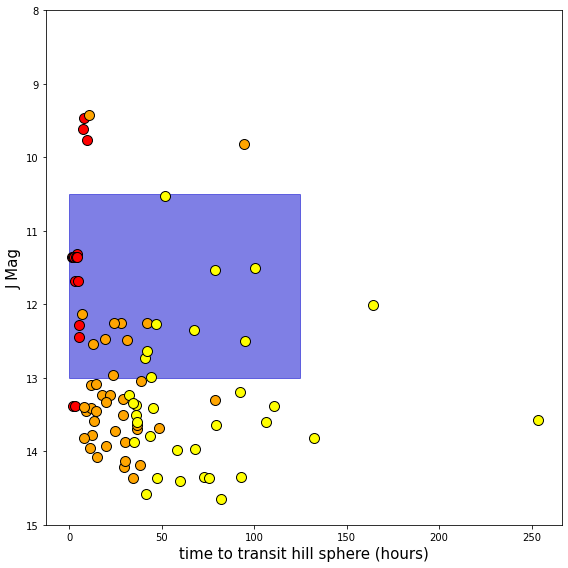

In [15]:
from matplotlib.patches import Rectangle

c = ((th / 3 * 5) < 300) & (hz_planets['tran_flag'] == 1)
pl.figure(figsize=(8, 8))
mdwarf = hz_planets[c]['st_teff'] < 3500
kdwarf = (hz_planets[c]['st_teff'] > 3500) & (hz_planets[c]['st_teff'] < 5000)
gdwarf = (hz_planets[c]['st_teff'] > 5000) & (hz_planets[c]['st_teff'] < 6000)
pl.plot(2*th[c][mdwarf], hz_planets[c]['sy_jmag'][mdwarf], 'o', color='red', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='m-dwarf')
pl.plot(2*th[c][kdwarf], hz_planets[c]['sy_jmag'][kdwarf], 'o', color='orange', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='k-dwarf')
pl.plot(2*th[c][gdwarf], hz_planets[c]['sy_jmag'][gdwarf], 'o', color='yellow', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='g-dwarf')
#pl.xlim(0, 100)
pl.ylim(15, 8)

#for t, jmag, hname in zip(2*th[c], hz_planets[c]['sy_jmag'], hz_planets[c]['pl_name']):
#        pl.annotate(hname, xy=(t+1, jmag), rotation=0, 
#                    bbox=dict(fc="white", lw=0.5, pad=2))

rect = Rectangle((0, 13), 75 * 5 / 3, -2.5, alpha=0.5, color='mediumblue')
pl.gca().add_patch(rect)
inrange = (th / 3 * 5 < 75) & (hz_planets['tran_flag'] == 1) & (hz_planets['sy_jmag'] < 13) & (hz_planets['sy_jmag'] > 10.5)

pl.xlabel('time to transit hill sphere (hours)', fontsize=15)
pl.ylabel('J Mag', fontsize=15)
#pl.legend(fontsize=12, loc='lower right')
pl.tight_layout()
pl.savefig('/Users/tgordon/Desktop/candidates_transit_time_jmag.pdf')

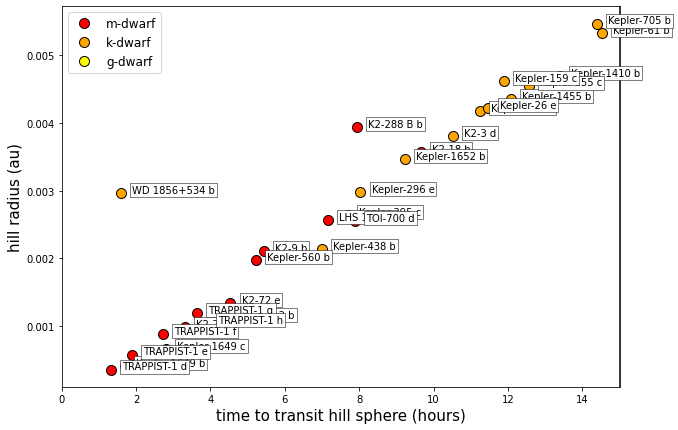

In [16]:
c = (th < 7.5) & (hz_planets['tran_flag'] == 1)
pl.figure(figsize=(10, 7))
mdwarf = hz_planets[c]['st_teff'] < 3500
kdwarf = (hz_planets[c]['st_teff'] > 3500) & (hz_planets[c]['st_teff'] < 5000)
gdwarf = (hz_planets[c]['st_teff'] > 5000) & (hz_planets[c]['st_teff'] < 6000)
pl.plot(2*th[c][mdwarf], rh[c][mdwarf], 'o', color='red', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='m-dwarf')
pl.plot(2*th[c][kdwarf], rh[c][kdwarf], 'o', color='orange', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='k-dwarf')
pl.plot(2*th[c][gdwarf], rh[c][gdwarf], 'o', color='yellow', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='g-dwarf')
pl.xlim(0, 15)
#pl.ylim(0.01, 0.03)

for t, r, pname in zip(th[c], rh[c], hz_planets[c]['pl_name']):
    pl.annotate(pname, xy=(2*t+0.3, r), rotation=0, 
                bbox=dict(fc="white", lw=0.5, pad=2))

pl.axvline(25 * 3 / 5, color='k')
pl.axvline(75 * 3 / 5, color='k')

pl.xlabel('time to transit hill sphere (hours)', fontsize=15)
pl.ylabel('hill radius (au)', fontsize=15)
pl.legend(fontsize=12)
pl.savefig('/Users/tgordon/Desktop/candidates_zoom.pdf')

In [17]:
from astropy.io import ascii
from astropy.table import unique
targets = hz_planets[inrange]
targets = unique(targets, keys='pl_name')
targets.sort('pl_hillrad')
targets.reverse()
fmtdict = {'pl_hillrad': '%0.3f', 'pl_minmass_med': '%0.3f', 'sy_jmag': '%0.3f'}
ascii.write(targets[(targets['sy_jmag'] < 13)]['pl_name', 'sy_jmag', 'pl_hillrad', 'st_teff', 'pl_minmass_med', 'pl_rade', 'cb_flag'], comment=False, delimiter='\t', formats=fmtdict)

pl_name	sy_jmag	pl_hillrad	st_teff	pl_minmass_med	pl_rade	cb_flag
Kepler-511 b	11.534	0.025	5812.0	0.077	5.04	0
Kepler-453 b	12.349	0.025	5527.0	0.094	6.204	1
KOI-1783.02	12.917	0.023	6215.0	0.062	4.4	0
Kepler-1661 b	12.729	0.016	5100.0	0.041	3.87	1
Kepler-22 b	10.523	0.015	5642.0	0.018	2.17	0
Kepler-967 c	12.991	0.014	5080.0	0.027	2.86	0
Kepler-452 b	12.263	0.012	5578.0	0.005	1.13	0
Kepler-69 c	12.631	0.012	5637.0	0.012	1.74	0
Kepler-62 f	12.256	0.012	4925.0	0.009	1.41	0
Kepler-1544 b	12.480	0.010	4798.0	0.014	1.69	0
Kepler-1540 b	12.250	0.009	4366.0	0.022	2.3	0
Kepler-62 e	12.256	0.008	4925.0	0.014	1.61	0
Kepler-186 f	12.473	0.005	3761.0	0.004	1.06	0
Kepler-440 b	12.960	0.005	4134.0	0.014	1.86	0
Kepler-155 c	12.533	0.005	3984.0	0.014	1.87	0
Kepler-438 b	12.130	0.002	3688.0	0.003	0.98	0
K2-9 b	12.451	0.002	3468.0	0.012	1.6	0
Kepler-560 b	12.276	0.002	3395.0	0.009	1.55	0
K2-72 e	11.685	0.001	3497.0	0.002	0.82	0
TRAPPIST-1 g	11.354	0.001	2559.0	0.005	1.127	0
Kepler-1512 b	11.315	0.001	3

In [18]:
targets.write('targets.txt', format='ascii')

In [19]:
from astropy.io import ascii
from astropy.table import unique
targets = hz_planets[inrange]
targets = unique(targets, keys='pl_name')
targets.sort('sy_jmag')
fmtdict = {'pl_hillrad': '%0.3f', 'pl_minmass_med': '%0.3f', 'sy_jmag': '%0.3f'}
ascii.write(targets[(targets['sy_jmag'] < 13)]['pl_name', 'sy_jmag', 'pl_hillrad', 'st_teff', 'pl_minmass_med', 'pl_rade', 'cb_flag'], comment=False, delimiter='\t', formats=fmtdict)

pl_name	sy_jmag	pl_hillrad	st_teff	pl_minmass_med	pl_rade	cb_flag
Kepler-22 b	10.523	0.015	5642.0	0.018	2.17	0
Kepler-1512 b	11.315	0.001	3419.0	0.001	0.8	0
TRAPPIST-1 h	11.354	0.001	2559.0	0.001	0.755	0
TRAPPIST-1 f	11.354	0.001	2559.0	0.003	1.045	0
TRAPPIST-1 e	11.354	0.001	2559.0	0.002	0.918	0
TRAPPIST-1 d	11.354	0.000	2559.0	0.001	0.772	0
TRAPPIST-1 g	11.354	0.001	2559.0	0.005	1.127	0
Kepler-511 b	11.534	0.025	5812.0	0.077	5.04	0
K2-72 c	11.685	0.001	3497.0	0.002	0.86	0
K2-72 e	11.685	0.001	3497.0	0.002	0.82	0
Kepler-438 b	12.130	0.002	3688.0	0.003	0.98	0
Kepler-1540 b	12.250	0.009	4366.0	0.022	2.3	0
Kepler-62 e	12.256	0.008	4925.0	0.014	1.61	0
Kepler-62 f	12.256	0.012	4925.0	0.009	1.41	0
Kepler-452 b	12.263	0.012	5578.0	0.005	1.13	0
Kepler-560 b	12.276	0.002	3395.0	0.009	1.55	0
Kepler-453 b	12.349	0.025	5527.0	0.094	6.204	1
K2-9 b	12.451	0.002	3468.0	0.012	1.6	0
Kepler-186 f	12.473	0.005	3761.0	0.004	1.06	0
Kepler-1544 b	12.480	0.010	4798.0	0.014	1.69	0
Kepler-155 c	12.533	0.005	3

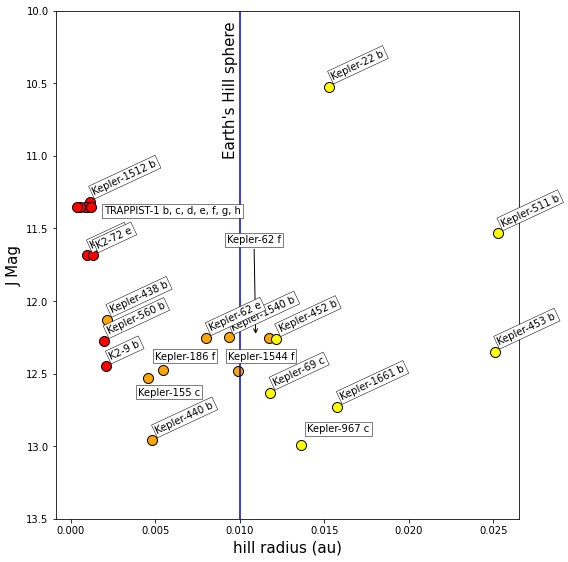

In [20]:
pl.figure(figsize=(8, 8))
mdwarf = targets['st_teff'] < 3500
kdwarf = (targets['st_teff'] >= 3500) & (targets['st_teff'] < 5000)
gdwarf = (targets['st_teff'] >= 5000) & (targets['st_teff'] < 6000)
pl.plot(targets['pl_hillrad'][mdwarf], targets['sy_jmag'][mdwarf], 'o', color='red', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='m-dwarf')
pl.plot(targets['pl_hillrad'][kdwarf], targets['sy_jmag'][kdwarf], 'o', color='orange', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='k-dwarf')
pl.plot(targets['pl_hillrad'][gdwarf], targets['sy_jmag'][gdwarf], 'o', color='yellow', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='g-dwarf')
#pl.xlim(0, 100)
pl.ylim(13.5, 7)

do_not_annotate = ['TRAPPIST-1 b', 
                   'TRAPPIST-1 c', 
                   'TRAPPIST-1 d', 
                   'TRAPPIST-1 e', 
                   'TRAPPIST-1 f', 
                   'TRAPPIST-1 g',
                   'TRAPPIST-1 h',
                   'Kepler-186 f', 
                   'Kepler-1544 b', 
                   'Kepler-967 c', 
                   'KOI-1783.02', 
                   'Kepler-155 c', 
                   'Kepler-62 f']
pl.annotate("Kepler-62 f", xy=(0.01095, 12.24), xytext=(0.00925, 11.6), arrowprops=dict(arrowstyle="->"), 
           bbox=dict(fc="white", lw=0.5, pad=2))
for r, jmag, hname in zip(targets['pl_hillrad'], targets['sy_jmag'], targets['pl_name']):
    if hname not in do_not_annotate:
        pl.annotate(hname, xy=(r+0.0001, jmag-0.05), rotation=25, 
                    bbox=dict(fc="white", lw=0.5, pad=2))

pl.annotate('TRAPPIST-1 b, c, d, e, f, g, h', xy=(0.002, 11.4), bbox=dict(fc="white", lw=0.5, pad=2))
pl.annotate('Kepler-186 f', xy=(0.005, 12.4),  bbox=dict(fc="white", lw=0.5, pad=2))
pl.annotate('Kepler-1544 f', xy=(0.0093, 12.4),  bbox=dict(fc="white", lw=0.5, pad=2))
pl.annotate('Kepler-967 c', xy=(0.014, 12.9), bbox=dict(fc="white", lw=0.5, pad=2))
pl.annotate('Kepler-155 c', xy=(0.004, 12.65), bbox=dict(fc="white", lw=0.5, pad=2))

pl.annotate('Earth\'s Hill sphere', xy=(0.009, 11), rotation=90, fontsize=15)
#pl.axvline(25 * 3 / 5, color='k')
#pl.axvline(75 * 3 / 5, color='k')
pl.axvline(0.01, color='mediumblue')
#pl.axvline(0.001, color='r')

pl.xlabel('hill radius (au)', fontsize=15)
pl.ylabel('J Mag', fontsize=15)
pl.ylim(13.5, 10)
#pl.xlim(0.003, 0.03)
#pl.legend(fontsize=12, loc='lower right')
pl.tight_layout()
pl.savefig('figures/candidates_jmag.pdf')
pl.savefig('/Users/tgordon/Desktop/candidates_hill_rad_jmag.pdf')

In [21]:
targets.sort('pl_name')
targets['pl_masse'] = targets['pl_minmass_med']*317.8
ascii.write(targets['pl_name', 
                    'sy_jmag', 
                    'pl_hillrad', 
                    'st_teff', 
                    'pl_rade', 
                    'pl_masse',
                    'ra',
                    'dec'], format='latex', 
            formats={'Hill radius (au)': '%0.3f', 'Mass, M$_\\bigoplus$': '%0.2f'}, 
            names=['planet name', 
                   'J mag', 
                   'Hill radius (au)', 
                   r'T$_\mathrm{eff}$ (K)', 
                   'Radius R$_\\bigoplus$', 'Mass, M$_\\bigoplus$', 'RA', 'Dec'])

\begin{table}
\begin{tabular}{cccccccc}
planet name & J mag & Hill radius (au) & T$_\mathrm{eff}$ (K) & Radius R$_\bigoplus$ & Mass, M$_\bigoplus$ & RA & Dec \\
K2-72 c & 11.685 & 0.001 & 3497.0 & 0.86 & 0.56 & 334.6227504 & -9.6120084 \\
K2-72 e & 11.685 & 0.001 & 3497.0 & 0.82 & 0.56 & 334.6227504 & -9.6120084 \\
K2-9 b & 12.451 & 0.002 & 3468.0 & 1.6 & 3.70 & 176.263724 & 0.0054085 \\
KOI-1783.02 & 12.917 & 0.023 & 6215.0 & 4.4 & 19.75 & 289.3414629 & 46.988155 \\
Kepler-1512 b & 11.315 & 0.001 & 3419.0 & 0.8 & 0.46 & 289.2744976 & 44.4704056 \\
Kepler-1540 b & 12.25 & 0.009 & 4366.0 & 2.3 & 6.94 & 283.3445555 & 41.2017544 \\
Kepler-1544 b & 12.48 & 0.010 & 4798.0 & 1.69 & 4.56 & 297.2852168 & 49.2124526 \\
Kepler-155 c & 12.533 & 0.005 & 3984.0 & 1.87 & 4.56 & 288.4957831 & 51.0819286 \\
Kepler-1661 b & 12.729 & 0.016 & 5100.0 & 3.87 & 13.00 & 285.1670927 & 41.9669383 \\
Kepler-186 f & 12.473 & 0.005 & 3761.0 & 1.06 & 1.30 & 298.652736 & 43.9549884 \\
Kepler-22 b & 10.523 & 0.015 &

In [22]:
transit_time = np.array([targets['pl_tranmid'] + i*targets['pl_orbper'] for i in range(100)]).T

In [23]:
from astropy.time import Time

def tobjd(time):
    return Time(time, format='isot', scale='utc').jd

import matplotlib.dates as dates
date_x = [dates.datestr2num(t[:10]) for t in Time(vis[:, 0], format='jd').iso]
plot_date = lambda jd: dates.datestr2num([(Time(jd, format='jd').iso)[:10] for jd in jd])

vis = np.loadtxt('../visibility/jwst_gtvt/Kepler-22.dat', skiprows=19, converters={0: tobjd})

NameError: name 'vis' is not defined

In [24]:
windows = np.loadtxt(open('../visibility/jwst_gtvt/Kepler-22.dat').readlines()[9:13], converters={0: tobjd, 1: tobjd})
breaks = [np.where(np.isclose(vis[:, 0], windows[:,1][i], rtol=1e-12))[0][0] for i in range(len(windows))]
breaks = np.insert(breaks, 0, 0)

NameError: name 'vis' is not defined

In [25]:
i = np.where(targets['pl_name'] == 'Kepler-22 b')[0][0]

print("max uncertainty: {0} hours".format(100*2*24*targets['pl_orbpererr1'][i]))

for j in range(len(early)):
    pl.axvline(transit_time[i][j], color='k')
[pl.fill_between(vis[:, 0][breaks[i]+1:breaks[i+1]], vis[:, 1][breaks[i]+1:breaks[i+1]], vis[:, 2][breaks[i]+1:breaks[i+1]], color='red') for i in range(len(breaks)-1)]
pl.xlim(vis[0, 0], vis[-1, 0])
x_ticks_labels = [t[:10] for t in Time(pl.xticks()[0], format='jd').iso]
pl.gca().set_xticklabels(x_ticks_labels, rotation=45, fontsize=10, ha='right');

max uncertainty: 6.1872 hours


NameError: name 'early' is not defined

In [324]:
import matplotlib.dates as dates
date_x = [dates.datestr2num(t[:10]) for t in Time(vis[:, 0], format='jd').iso]
plot_date = lambda jd: dates.datestr2num([(Time(jd, format='jd').iso)[:10] for jd in jd])

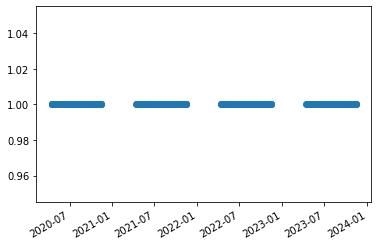

In [325]:
pl.plot_date(plot_date(vis[:, 0]), np.ones_like(vis[:, 0]))
pl.gcf().autofmt_xdate()

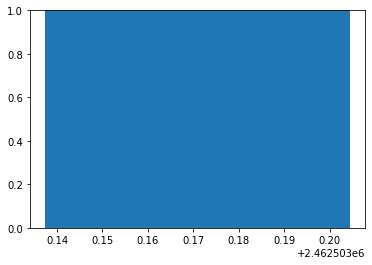

In [105]:
pl.axvspan(early[i][j], late[i][j])

In [127]:
targets['pl_orbpererr1']

0.0032
0.00137
0.00119
5.479e-05
0.002415
0.0004189
0.002102
0.000136
0.004164
0.06
0.001737


In [20]:
mr.Rstat2M(mean=9.21 / 11.2089, std=0.5 / 11.2089, unit='Jupiter', sample_size=100, grid_size=100)

(7.658277115896085, 42.717526400894585, 7.440080380235762)

In [26]:
for t in targets:
    print(t['pl_name'], " ", t['st_teff'], " ", 1.02*t['st_teff'])

K2-72 c   3497.0   3566.94
K2-72 e   3497.0   3566.94
K2-9 b   3468.0   3537.36
KOI-1783.02   6215.0   6339.3
Kepler-1512 b   3419.0   3487.38
Kepler-1540 b   4366.0   4453.32
Kepler-1544 b   4798.0   4893.96
Kepler-155 c   3984.0   4063.6800000000003
Kepler-1661 b   5100.0   5202.0
Kepler-186 f   3761.0   3836.2200000000003
Kepler-22 b   5642.0   5754.84
Kepler-438 b   3688.0   3761.76
Kepler-440 b   4134.0   4216.68
Kepler-452 b   5578.0   5689.56
Kepler-453 b   5527.0   5637.54
Kepler-511 b   5812.0   5928.24
Kepler-560 b   3395.0   3462.9
Kepler-62 e   4925.0   5023.5
Kepler-62 f   4925.0   5023.5
Kepler-69 c   5637.0   5749.74
Kepler-967 c   5080.0   5181.6
TRAPPIST-1 d   2559.0   2610.18
TRAPPIST-1 e   2559.0   2610.18
TRAPPIST-1 f   2559.0   2610.18
TRAPPIST-1 g   2559.0   2610.18
TRAPPIST-1 h   2559.0   2610.18


In [98]:
targets[targets['pl_name'] == 'Kepler-62 e']['pl_hilltime']

11.44490985940632


In [96]:
from astropy.time import Time
Time(2454983.404, format='jd').iso

'2009-05-31 21:41:45.600'